# Trabalho 2 - Conway’s Game of Life

Paulo Jorge Fernandes Freitas - A100053 & Pedro Manuel Pereira dos Santos - A100110

2. O Conway’s Game of Life é um exemplo conhecido de um autómato celular . Aqui vamos modificar as regras do autómato de forma a usar um espaço de estados finito
    1. O espaço de estados é finito definido por uma grelha de células booleanas (morta=0/viva=1) de dimensão $\,N\times N\,$ (com $N>3$) identificadas por índices $\,(i,j)\in \{1..N\}$.  Estas $\;N^2\;$ células são aqui referidas como “normais”. 
    2. No estado inicial todas as células normais estão mortas excepto  um quadrado $\,3\times 3\,$, designado por “centro”, aleatoriamente posicionado formado apenas por células vivas.
    3. Adicionalmente existem $\,2\,N+1\,$ “células da borda” que correspondem a um dos índices, $i$ ou $j$, ser zero. As células da borda têm valores constantes que, no estado inicial, são gerados aleatoriamente com uma probabilidade $\,\rho\,$ de estarem vivas.
    4. As células normais o autómato modificam o estado de acordo com a regra “B3/S23”: i.e. a célula nasce (passa de $0$ a $1$) se tem exatamente 3 vizinhos vivos e sobrevive (mantém-se viva) se o número de vizinhos vivos é 2 ou 3, caso contrário morre ou continua morta. 
    
**Nota:** A célula $\;(i_0,j_0)\;$ e $\,(i_1,j_1)\,$ são vizinhas sse $\;(i_0-i_1=\pm 1) \,\lor\, (j_0-j_1 = \pm 1)$

## Análise do problema

Após a construção do Conway’s Game of Life, é necessario:

A. Construir uma máquina de estados finita que represente este autómato;  
B. Verificar se se conseguem provar as seguintes propriedades:
1. Todos os estados acessíveis contém pelo menos uma célula.
2. Toda a célula normal está viva pelo menos uma vez em algum estado acessível.

**Variáveis:**

grid_N -> duplo com as linhas e colunas da matriz  
gris -> matriz  
x -> x do centro do quadrado 3x3  
y -> y do centro do quadrado 3x3  
updated_grid -> matriz atualizasa  
days -> dias que o Game of life occorre  
alive -> numero de células vivas vizinhas e a propia numa certa posição  

## Implementação

Começamos por importar as bibliotecas:
1. numpy para a matriz
2. random para gerar aleatoriedades
3. matplotlib.pyplot para dar print da matriz

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

Criação da matriz com tudo a zero

In [2]:
grid_N = (100,100)

grid = np.zeros([grid_N[0],grid_N[1]])

## Condições

Condiçao da alinea b), geração um quadrado 3x3 aleatoriamente (tirando centros como (0,0)).

In [3]:
x = random.randint(2,grid_N[0]-2)
y = random.randint(2,grid_N[1]-2)

for i in range(-1, 2):
    for j in range(-1, 2):
        grid[x + i][y + j] = 1

Condiçao da alinea c), geração aleatoria de celulas vivas nas laterais

In [4]:
for i in random.sample(range(0,grid_N[0]),random.randint(1,grid_N[0]-1)):
    grid[i][0]=1

for j in random.sample(range(0,grid_N[1]),random.randint(1,grid_N[1]-1)):
    grid[0][j]=1

## Programa do Conway’s Game of Life

Faz days iterações com as regras do Conway’s Game of Life

In [5]:
days = 100

for d in range(days):    
    updated_grid = np.zeros([grid.shape[0], grid.shape[1]])
    
    for row, col in np.ndindex(grid.shape):
        #contar quantos vivos
        alive = np.sum(grid[row-1:row+2, col-1:col+2]) - grid[row, col]
        
        if grid[row, col] == 1:
            # se alive < 2 or alive > 3, nao e necessario fazer nada porque ja esta a zero
            # se tiver 2 ou 3 vizinhos, a celula é viva
            if 2 <= alive <= 3:
                updated_grid[row, col] = 1
        else:
            #se tiver 3 vizinhos, a celula é viva
            if alive == 3:
                updated_grid[row, col] = 1
    grid = updated_grid

## Impressão dos resultados

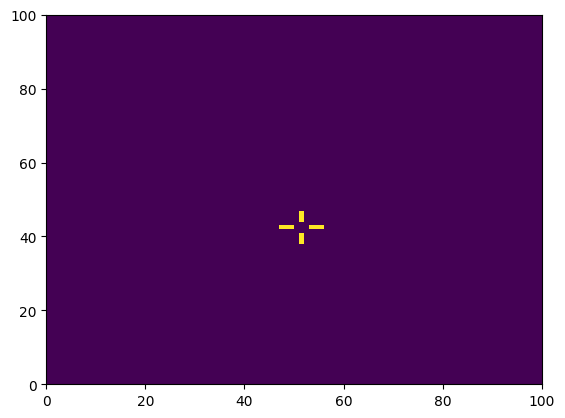

In [6]:
plt.pcolormesh(grid)
plt.axis('on')
plt.show()

In [3]:
x = random.randint(2,grid_N[0]-2)
y = random.randint(2,grid_N[1]-2)

for i in range(-1, 2):
    for j in range(-1, 2):
        grid[x + i][y + j] = True

In [4]:
for i in random.sample(range(0,grid_N[0]),random.randint(1,grid_N[0]-1)):
    grid[i][0]= True

for j in random.sample(range(0,grid_N[1]),random.randint(1,grid_N[1]-1)):
    grid[0][j]= True

In [ ]:
##Ignora o que esta para cima

In [1]:
from pysmt.shortcuts import Symbol, And, Solver, Not, Equals, Implies, LE, Int, GE, Plus, Or
from pysmt.typing import BOOL
from pysmt.smtlib.parser import SmtLibParser
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
grid_N = (10,10)

grid = [[False for _ in range(grid_N[0])] for _ in range(grid_N[1])]

In [3]:
from pysmt.shortcuts import Symbol, And, Or, Not, Equals, Implies, to_smtlib, Solver, Ite, TRUE, FALSE
from pysmt.typing import BOOL

# Tamanho do grid
n = grid_N[0]
m = grid_N[1]

grid = np.array([[Symbol(f'cell_{i}_{j}', BOOL) for j in range(m)] for i in range(n)])

# Crie um solver SMT
solver = Solver(name="z3")

# Defina as regras do Jogo da Vida
rules = []
for i in range(n):
    for j in range(m):
        neighbors = np.array([])
        for x in [-1, 0, 1]:
            for y in [-1, 0, 1]:
                if x == 0 and y == 0:
                    continue
                ni, nj = i + x, j + y
                if 0 <= ni < n and 0 <= nj < m:
                    neighbors = np.append(neighbors, grid[ni][nj])
        
        #for neighbor in neighbors:
            #print(neighbor.is_true())
        alive_neighbors = sum(neighbors)
        current_cell = grid[i][j]
        rule = Or(And(current_cell, Equals(alive_neighbors, 2)),
                  And(current_cell, Equals(alive_neighbors, 3)),
                  And(Not(current_cell), Equals(alive_neighbors, 3)))
        rules.append(rule)

# Impor a regra global
global_rule = And(rules)

# Adicione a regra ao solver
solver.add_assertion(global_rule)

# Resolva o problema
if solver.solve():
    model = solver.get_model()
    for i in range(n):
        for j in range(m):
            cell_value = model.get_py_value(grid[i][j])
            print(f'cell_{i}_{j}: {cell_value}')
else:
    print("Nenhuma solução encontrada.")

PysmtTypeError: Expecting bool, got <class 'int'>